# Fake news detection 

Importing libraries 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from time import time
import string
#import itertools
from pprint import pprint
from nltk import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import PassiveAggressiveClassifier, LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

# Data Exploration

In [3]:
df = pd.read_csv("https://s3.amazonaws.com/assets.datacamp.com/blog_assets/fake_or_real_news.csv")
print(df.shape)

(6335, 4)


In [4]:
df.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [5]:
df.describe()

,Unnamed: 0
count,6335.000000
mean,5280.415627
std,3038.503953
min,2.000000
25%,2674.500000
50%,5271.000000
75%,7901.000000
max,10557.000000


In [6]:
df.info ()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
Unnamed: 0    6335 non-null int64
title         6335 non-null object
text          6335 non-null object
label         6335 non-null object
dtypes: int64(1), object(3)
memory usage: 198.0+ KB


In [7]:
df.isnull().any()

Unnamed: 0    False
title         False
text          False
label         False
dtype: bool

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math as math
from pylab import rcParams

%matplotlib inline

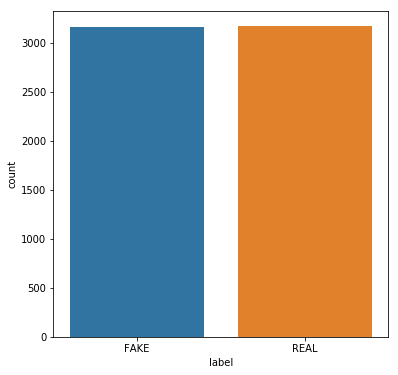

In [12]:
plt.figure (figsize=(6,6))
p = sns.countplot(data=df,x = 'label',)

In [15]:
df.loc[df['label']== 0, 'label'] = 'REAL'
df.loc[df['label']== 1, 'label'] = 'FAKE'
df.columns
df['label'].value_counts()

REAL    3171
FAKE    3164
Name: label, dtype: int64

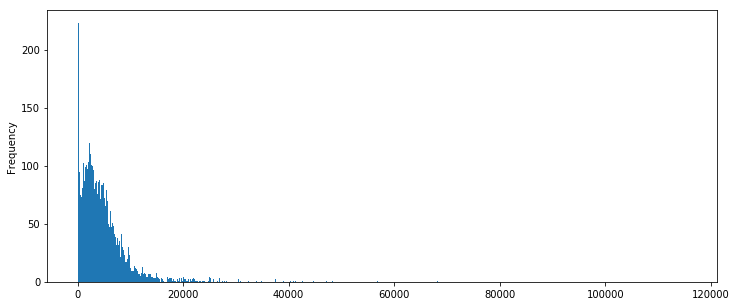

In [18]:
# Draw a graph of text length verse frequency

import matplotlib
%matplotlib inline
df['text'].str.len().plot(kind = 'hist', bins = 1000, figsize = (12,5))

# Extracting the training data

In [34]:
y = df.label 
df.drop("label", axis=1) 
X_train, X_test, y_train, y_test = train_test_split(df['text'], y, test_size=0.33, random_state=42)

In [35]:
print(X_train.shape)
print(type(X_train))
print(X_train.head())
print(X_test.shape)
print(type(X_test))
print(X_test.head())

(4244,)
<class 'pandas.core.series.Series'>
5593    The next president is most likely to face an i...
6067    Following news of FBI Director James Comey’s d...
3026    Interviews A protester throws a glass bottle c...
4385    Will it be representative government or thugoc...
120     It is increasingly apparent that the U.S. war ...
Name: text, dtype: object
(2091,)
<class 'pandas.core.series.Series'>
1357    Will Trump pull a Brexit times ten? What would...
2080    Clintons Are Under Multiple FBI Investigations...
2718    Dispatches from Eric Zuesse This piece is cros...
812     Print \n[Ed. – Every now and then the facade c...
4886    Nanny In Jail After Force Feeding Baby To Deat...
Name: text, dtype: object


Let’s initialize a TfidfVectorizer with stop words from the English language and a maximum document frequency of 0.7 (terms with a higher document frequency will be discarded). Stop words are the most common words in a language that are to be filtered out before processing the natural language data. And a TfidfVectorizer turns a collection of raw documents into a matrix of TF-IDF features.

In [36]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7) 
tfidf_train = tfidf_vectorizer.fit_transform(X_train) 
tfidf_test = tfidf_vectorizer.transform(X_test)

In [37]:
print(tfidf_train.shape)
print(tfidf_test.shape)

(4244, 56801)
(2091, 56801)


In [38]:
print(tfidf_vectorizer.get_feature_names()[-10:])

['שתי', 'תאמצנה', 'תוצאה', 'תחל', 'תיירות', 'תנותק', 'תעודת', 'תתרכז', 'القادمون', 'عربي']


In [39]:
tfidf_df = pd.DataFrame(tfidf_train.A, columns=tfidf_vectorizer.get_feature_names())

In [40]:
count_vectorizer = CountVectorizer(stop_words='english')
count_train = count_vectorizer.fit_transform(X_train)
count_test = count_vectorizer.transform(X_test)

In [41]:
count_vectorizer.get_feature_names()[:10]

['00',
 '000',
 '0000',
 '000000031',
 '00000031',
 '0001',
 '000billion',
 '000ft',
 '000km',
 '001']

In [20]:
tfidf_df.head()

,00,000,0000,000000031,00000031,0001,000billion,000ft,000km,001,...,שתי,תאמצנה,תוצאה,תחל,תיירות,תנותק,תעודת,תתרכז,القادمون,عربي
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Comparing Models

In [42]:
import sklearn.metrics as metrics

In [44]:
def classify_and_fit(clf, X_train, y_train, X_test, y_test, class_labels = ['FAKE', 'REAL']):
    print("Classifier : ", clf )
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    score = metrics.accuracy_score(y_test, pred)
    print("Accuracy:   %0.3f" % score)
    print("\nConfusion Matrix :")
    #print(pd.crosstab(y_test, pred, rownames=['True'], colnames=['Predicted'], margins=True))
    cm = metrics.confusion_matrix(y_test, pred, labels=class_labels)
    print(cm)
    print("\nReport :")    
    print(classification_report(y_test, pred, target_names=class_labels))
    return clf

In [45]:
clf = MultinomialNB() 
classify_and_fit(clf, tfidf_train, y_train, tfidf_test, y_test)

Classifier :  MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
Accuracy:   0.815

Confusion Matrix :
[[ 704  367]
 [  19 1001]]

Report :
              precision    recall  f1-score   support

        FAKE       0.97      0.66      0.78      1071
        REAL       0.73      0.98      0.84      1020

   micro avg       0.82      0.82      0.82      2091
   macro avg       0.85      0.82      0.81      2091
weighted avg       0.86      0.82      0.81      2091



MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

# Testing Linear Models

In [46]:
linear_clf = PassiveAggressiveClassifier(n_iter=50)
classify_and_fit(linear_clf, tfidf_train, y_train, tfidf_test, y_test)

Classifier :  PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
              early_stopping=False, fit_intercept=True, loss='hinge',
              max_iter=None, n_iter=50, n_iter_no_change=5, n_jobs=None,
              random_state=None, shuffle=True, tol=None,
              validation_fraction=0.1, verbose=0, warm_start=False)


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Accuracy:   0.941

Confusion Matrix :
[[1012   59]
 [  64  956]]

Report :
              precision    recall  f1-score   support

        FAKE       0.94      0.94      0.94      1071
        REAL       0.94      0.94      0.94      1020

   micro avg       0.94      0.94      0.94      2091
   macro avg       0.94      0.94      0.94      2091
weighted avg       0.94      0.94      0.94      2091



PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
              early_stopping=False, fit_intercept=True, loss='hinge',
              max_iter=None, n_iter=50, n_iter_no_change=5, n_jobs=None,
              random_state=None, shuffle=True, tol=None,
              validation_fraction=0.1, verbose=0, warm_start=False)

# Logistic regression 

In [48]:
log_reg = LogisticRegression()
classify_and_fit(log_reg, tfidf_train, y_train, tfidf_test, y_test)

Classifier :  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy:   0.915

Confusion Matrix :
[[1008   63]
 [ 115  905]]

Report :
              precision    recall  f1-score   support

        FAKE       0.90      0.94      0.92      1071
        REAL       0.93      0.89      0.91      1020

   micro avg       0.91      0.91      0.91      2091
   macro avg       0.92      0.91      0.91      2091
weighted avg       0.92      0.91      0.91      2091



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

# Random Forest classifier 

In [50]:
from sklearn.ensemble import RandomForestClassifier
ran_class= RandomForestClassifier()
classify_and_fit(ran_class, tfidf_train, y_train, tfidf_test, y_test)

Classifier :  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy:   0.852

Confusion Matrix :
[[946 125]
 [185 835]]

Report :
              precision    recall  f1-score   support

        FAKE       0.84      0.88      0.86      1071
        REAL       0.87      0.82      0.84      1020

   micro avg       0.85      0.85      0.85      2091
   macro avg       0.85      0.85      0.85      2091
weighted avg       0.85      0.85      0.85      2091



RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

# Count versus TF-IDF Features


In [25]:
def most_informative_feature_for_binary_classification(vectorizer, classifier, n=100):
    class_labels = classifier.classes_
    feature_names = vectorizer.get_feature_names()
    topn_class1 = sorted(zip(classifier.coef_[0], feature_names))[:n]
    topn_class2 = sorted(zip(classifier.coef_[0], feature_names))[-n:]
    for coef, feat in topn_class1:
        print(class_labels[0], coef, feat)
    print()
    for coef, feat in reversed(topn_class2):
        print(class_labels[1], coef, feat)


most_informative_feature_for_binary_classification(tfidf_vectorizer, linear_clf, n=30)

FAKE -4.8678388575385165 2016
FAKE -4.669355680655084 october
FAKE -3.9378534295177383 hillary
FAKE -3.005183944563461 article
FAKE -2.930291147149272 share
FAKE -2.8001222080118473 november
FAKE -2.6850259006739052 election
FAKE -2.634283806825962 snip
FAKE -2.3687424292875168 source
FAKE -2.3446236709040074 podesta
FAKE -2.3396312377119175 email
FAKE -2.2759223773854123 print
FAKE -2.258478579622267 mosul
FAKE -2.2043141955091823 just
FAKE -2.1912364437847485 corporate
FAKE -1.9605036727410252 wikileaks
FAKE -1.8656296258274236 com
FAKE -1.827700377173269 demand
FAKE -1.8071946884340138 oct
FAKE -1.7986503083985215 video
FAKE -1.7825816521392983 healthcare
FAKE -1.7821680915882692 pay
FAKE -1.7579073877699516 advertisement
FAKE -1.7365419508622124 reuters
FAKE -1.7145208052350696 establishment
FAKE -1.6928333940595859 stated
FAKE -1.6900631212652195 ___
FAKE -1.6807246833123908 photo
FAKE -1.6238669260542902 donald
FAKE -1.6049503797420361 28

REAL 5.11930226611206 said
REAL 3.209718